In [5]:
import os
import requests
from langchain.chains import ConversationalRetrievalChain
#from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_pinecone import PineconeVectorStore
from langchain_community.embeddings import HuggingFaceEmbeddings
from dotenv import load_dotenv

load_dotenv()

True

In [21]:
from langgraph.graph import StateGraph, START, END
from embedding import find_match , get_weather, get_conversation_chain
import os
from typing import Annotated
from typing_extensions import TypedDict

def find_match(question):
    query = f"""
    You are a knowledgeable assistant. Use the provided context from the database to answer the question accurately.
    Question: {question}
    - If the answer is not present in the database/context, respond exactly with: "I don't know."
    - Do not make up answers or add extra details outside the provided context.
    """

    PINECONE_INDEX_NAME = os.getenv('PINECONE_INDEX')

    # Use the same Hugging Face model as you did in embedding upload
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"  # 768-dim to match Pinecone index
    )

    # Load existing Pinecone index
    vector_search = PineconeVectorStore.from_existing_index(
        index_name=PINECONE_INDEX_NAME,
        embedding=embeddings
    )

    # Create conversation chain
    conversation_chain = get_conversation_chain(vector_search)

    # Run the query
    response = conversation_chain({"question": query})

    return response.get('answer', "")


# ---- STATE ----
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    

# ---- DECISION FUNCTION ----
def decide_action(state: AgentState):
    question = state.get("question", "").lower()
    weather_keywords = ["weather", "temperature", "forecast", "climate"]

    if any(word in question for word in weather_keywords):
        return "weather_node"
    else:
        return "find_match_node"

# ---- WEATHER NODE ----
def weather_node(state: AgentState):
    city_name = state.get("city_name") or state.get("question")
    state["answer"] = get_weather(city_name)
    return state

# ---- FIND MATCH NODE ----
def find_match_node(state: AgentState):
    question = state.get("question", "")
    state["answer"] = find_match(question)
    return state

# ---- GRAPH BUILDER ----
builder = StateGraph(AgentState)

builder.add_node("decision_node", lambda s: s)  # Keeps state as-is
builder.add_node("weather_node", weather_node)
builder.add_node("find_match_node", find_match_node)

# Flow: START → decision → (weather/find match) → END
builder.add_edge(START, "decision_node")

builder.add_conditional_edges(
    "decision_node",
    decide_action,  # This decides where to go next
    {
        "weather_node": "weather_node",
        "find_match_node": "find_match_node"
    }
)

builder.add_edge(["weather_node", "find_match_node"], END)

graph = builder.compile()

# Example run
result = graph.invoke({"question": "What is fact table"})
print(graph)

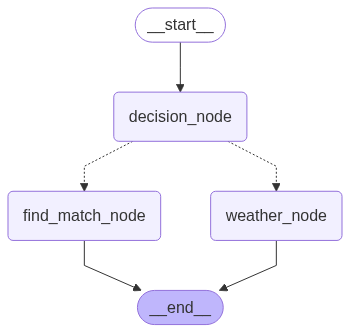

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [14]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
def get_conversation_chain(vector_search):
    # You can still use Gemini or GPT here, I kept GPT-4o from your code
    
    llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", temperature= 0)
    memory = ConversationBufferWindowMemory(
        k=3, memory_key="chat_history", return_messages=True
    )

    return ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=vector_search.as_retriever(),
        memory=memory
    )
    
@tool
def get_weather(city_name):
    """
    Fetch real-time weather data for a given city using OpenWeather API.
    """
    api_key = os.getenv("OPENWEATHER_API_KEY")  # Store your API key in .env file
    base_url = "https://api.openweathermap.org/data/2.5/weather"

    params = {
        "q": city_name,
        "appid": api_key,
        "units": "metric"  # Use "imperial" for Fahrenheit
    }

    try:
        response = requests.get(base_url, params=params)
        data = response.json()

        if response.status_code != 200:
            return f"Error: {data.get('message', 'Unable to fetch weather data')}"

        # Extract relevant info
        city = data["name"]
        country = data["sys"]["country"]
        temperature = data["main"]["temp"]
        feels_like = data["main"]["feels_like"]
        weather_condition = data["weather"][0]["description"]

        return f"Weather in {city}, {country}: {temperature}°C, feels like {feels_like}°C, {weather_condition}."
    
    except Exception as e:
        return f"An error occurred: {e}"

@tool
def find_match(question):
    """
    Retrieve the most relevant answer from the Pinecone vector database
    based on the user's question.

    This function:
    1. Formats the user question into a structured query with clear instructions.
    2. Uses Hugging Face embeddings ("all-mpnet-base-v2") to encode the query.
    3. Searches an existing Pinecone index for relevant context.
    4. Passes the matched context to a conversation chain for generating the final answer.

    Rules for answering:
    - If the answer is not found in the database/context, return exactly "I don't know."
    - Do not generate or add details outside the provided context.

    Args:
        question (str): The user's input question.

    Returns:
        str: The most relevant answer from the database, or "I don't know." if no match is found.
    """
    query = f"""
    You are a knowledgeable assistant. Use the provided context from the database to answer the question accurately.
    Question: {question}
    - If the answer is not present in the database/context, respond exactly with: "I don't know."
    - Do not make up answers or add extra details outside the provided context.
    """

    PINECONE_INDEX_NAME = os.getenv('PINECONE_INDEX')

    # Use the same Hugging Face model as used in embedding upload
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"  # 768-dim to match Pinecone index
    )

    # Load existing Pinecone index
    vector_search = PineconeVectorStore.from_existing_index(
        index_name=PINECONE_INDEX_NAME,
        embedding=embeddings
    )

    # Create conversation chain
    conversation_chain = get_conversation_chain(vector_search)

    # Run the query
    response = conversation_chain({"question": query})

    return response.get('answer', "")

tools = [find_match, get_weather]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)


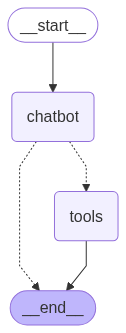

In [29]:
def chatbot(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(AgentState)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
def call_graph(query: str):
    state = graph.invoke({"messages": [{"role": "user", "content": query}]})
    return state["messages"][-1].content
# state = graph.invoke({"messages": [{"role": "user", "content": "tell me weather in Pune?"}]})
# print(state["messages"][-1].content)
call_graph("what is dimension table")

'The dimension table contains the attributes of the dataset such as customers, region, etc. Dimension tables contain at least one column which is unique.'

In [25]:
state = graph.invoke({"messages": [{"role": "user", "content": "what is fact table?"}]})
print(state["messages"][-1].content)

The fact table contains the transaction data (Sales Data). The same is not applicable to fact tables regarding having at least one unique column, unlike dimension tables.
